In [9]:
# 指定CPU跑
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# 只输出最后一个表达式
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity =  'all' #'last_expr' #

In [ ]:
import numpy as np
np.__version__

In [1]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.0.0'

# 使用TensorFlow通过回归验证通用近似定理
***
神经网络中，我们把神经元看作网络节点，在节点处通常是使用一个非线性函数$\sigma()$去作用到输入信号上面。~~而在不同层之间的神经元之间会相互连接.~~ 而第n层神经元与第n+1层神经元连接（单向），而这种连接在神经网络中以权重w进行表示。  
那么**信号由第n层到第n+1层中的第i个神经元**，便可以表示成如下(其中m表示此批次的样本数)：
$$
x_i^{(n+1)} = \sigma(\sum_m{w^{(n)}_m x^{(n)}_m + b^{(n)}})
$$
从上面的公式也可以看出，n+1层的神经元通常会与上一层的每个神经元存在联系（全连接时），而在单层神经元之间彼此通常是没有直接连接的。那么如果我们能证明这一层的神经元之间是相互正交的，那么我们就证明了这一层神经元可以拟合得到任意函数。  
证明：  

pass

## 自定义模型实现：

### 批操作生成函数

对输入数据应保持形状为(m,num_feature)， 这样输入神经网络后便可以以矩阵相乘的形式得到最后为(m, num_class)的结果，即  
(m, num_feature)* (num_feature, hidden1)* (hidden1, hidden2)* ... * (hiddenN, num_classis)

In [3]:
tf.test.is_gpu_available()

True

In [86]:
# 批操作
x_data = np.linspace(0,10,100)

def genData(x_data,batch_size=100):
    L = len(x_data)
    idx = np.arange(0,L)
    count=0
    while True: # 让其一轮结束后开始新一轮
#         count += 1
        np.random.shuffle(idx)
        batchs = L//batch_size
        for i in range(batchs):
#             print(count)
            x = x_data[idx][i*batch_size:(i+1)*batch_size].reshape(batch_size,-1)
            yield x,tf.constant(np.sin(x))

In [87]:
g = genData(x_data)

In [88]:
X,Y = next(g) 
X.shape,Y.shape

((100, 1), TensorShape([100, 1]))

In [89]:
X = tf.constant(X)
X.shape

TensorShape([100, 1])

In [7]:
# Y = np.square(X)

print(Y.shape)
print(X.shape)

(100, 1)
(100, 1)


In [8]:
X.shape

(100, 1)

In [9]:
# tf.Variable(np.random.randn(50,3))@tf.Variable(np.random.randn(3,3))+ tf.Variable(np.random.randn(50,3))
a = np.random.randn(5,3,3)
print('第0，1维度\n',a[:,:,1]) # 返回 5*3
print('第1，2维度\n',a[1,:,:]) # 返回3*3
print('第0，2维度\n',a[:,1,:]) # 5*3

第0，1维度
 [[ 0.06131132  0.80349074 -1.67094703]
 [ 0.36676751  1.47183589 -2.08652062]
 [-0.16343244 -0.56952052  1.52092298]
 [-0.9427365   0.15401984 -0.24667933]
 [-0.9935122  -1.37162769 -2.492439  ]]
第1，2维度
 [[-0.25203083  0.36676751  0.50159692]
 [ 0.07135802  1.47183589  0.81844132]
 [ 0.42613956 -2.08652062  0.8498975 ]]
第0，2维度
 [[ 2.27506758  0.80349074  1.56901166]
 [ 0.07135802  1.47183589  0.81844132]
 [-0.27540601 -0.56952052 -0.20441273]
 [-0.6339931   0.15401984  0.59397584]
 [-0.94173637 -1.37162769 -0.40335795]]


In [10]:
np.random.randn(5,3)

array([[-0.67530929, -0.33704642,  0.94623745],
       [-0.15639243,  0.23822872,  0.31874819],
       [-0.57434848,  0.14348904, -0.31155643],
       [ 0.51636833,  0.13926761,  1.43720749],
       [-0.06413768,  0.85131275, -0.03145581]])

In [90]:
class Model:
    def __init__(self, input_shape=[50,1],num_layers = 2):
        '''input_shape = [batch_size, feature_size]'''
        # 把这里的input_shape　使用类似placeholder的方式先不要确定。在后面model(X)的时候读取Ｘ的shape去得到它的input_shape
        
        self.batch_size, self.num_feature = input_shape[0], input_shape[1]
        self.num_layers = num_layers

        hidden1, hidden2 = 100,100 # 单个隐藏层神经元个数
        out_put = 1
        self.w0 = tf.Variable(np.random.randn(self.num_feature, hidden1), name = 'weight0')
        self.b0 = tf.Variable(np.random.randn(self.batch_size, hidden1), name = 'bias0')
        
        self.w1 = tf.Variable(np.random.randn(hidden1, hidden2, num_layers), name = 'weight1')
        self.b1 = tf.Variable(np.random.randn(self.batch_size, hidden2, num_layers), name = 'bias1')
        
        self.w2 = tf.Variable(np.random.randn(hidden2, out_put), name = 'weight2')
        self.b2 = tf.Variable(np.random.randn(self.batch_size, out_put), name = 'bias2')
        
        self.wp = tf.Variable(np.random.randn(out_put, out_put), name = 'weight_predict')
        self.bp = tf.Variable(np.random.randn(self.batch_size, out_put), name = 'weight_predict')
        


    def __call__(self,X):
        
#         out = tf.nn.sigmoid(X@ self.w0 + self.b0) # 输入层
        out = tf.nn.sigmoid(tf.multiply(X, self.w0)+ self.b0) # 输入层
        for i in range(self.num_layers):
             out = tf.nn.sigmoid(out @ self.w1[:,:,i] + self.b1[:,:,i])# 隐藏层
    
        out = tf.nn.sigmoid(out@self.w2+self.b2)# 输出层的前一层
        out = out @ self.wp + self.bp # 输出层(预测层)
        return out
        
def lossfunc(OUT,Y):
    return tf.reduce_mean(tf.square(OUT-Y)) 

model = Model(input_shape=[100,1], num_layers=1)
pred = model(X)
# print(pred)
loss = lossfunc(pred,Y)
loss

<tf.Tensor: id=491829, shape=(), dtype=float64, numpy=1.848616216377262>

In [91]:
# Stochastic Gradient Descent Optimizer.
learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate)
# optimizer = tf.optimizers.Adadelta(learning_rate)

In [92]:
# Optimization process. 
def run_optimization():
    # 将导数的计算封装在 GradientTape 中
    with tf.GradientTape() as g:
        loss = lossfunc(model(X),Y)
     
    W = [model.w0, model.b0,model.w1, model.b1,model.w2, model.b2, model.wp, model.bp];
    # 计算loss对W和b的导数：
    gradients = g.gradient(loss, Ｗ)
    # 根据梯度更新W,b
    optimizer.apply_gradients(zip(gradients, W))

In [95]:
# Run training for the given number of steps.
training_steps = 1000
display_step=100

writer = tf.summary.create_file_writer("./mylogs")
with writer.as_default(): # 这是为了后面的tf.summary.scalar()
    for step in range(1, training_steps + 1):
        X,Y = next(genData(x_data))

        # Run the optimization to update W and b values.
        run_optimization()

        tf.summary.scalar('loss',loss, step=step)
        writer.flush()
        if step % display_step == 0:
            pred = model(X)
            loss = lossfunc(pred,Y)
            print("\r step: {}, loss: {}".format(step, loss))


<tf.Tensor: id=589494, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=589591, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=589688, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=589785, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=589882, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=589979, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=590076, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=590173, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=590270, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=590367, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=590464, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=590561, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=590658, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=590755, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=590852, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=590949, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=591046, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=591143, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=591240, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=591337, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=591434, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=591531, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=591628, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=591725, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=591822, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=591919, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592016, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592113, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592210, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592307, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592404, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592501, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592598, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592695, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592792, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592889, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=592986, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=593083, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=593180, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=593277, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=593374, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=593471, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=593568, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=593665, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=593762, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=593859, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=593956, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=594053, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=594150, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=594247, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=594344, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=594441, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=594538, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=594635, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=594732, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=594829, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=594926, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595023, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595120, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595217, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595314, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595411, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595508, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595605, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595702, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595799, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595896, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=595993, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=596090, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=596187, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=596284, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=596381, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=596478, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=596575, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=596672, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=596769, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=596866, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=596963, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=597060, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=597157, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=597254, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=597351, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=597448, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=597545, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=597642, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=597739, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=597836, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=597933, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=598030, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=598127, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=598224, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=598321, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=598418, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=598515, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=598612, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=598709, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=598806, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=598903, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=599000, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=599097, shape=(), dtype=bool, numpy=True>

 step: 100, loss: 0.7122129601003376


<tf.Tensor: id=599226, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=599323, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=599420, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=599517, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=599614, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=599711, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=599808, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=599905, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600002, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600099, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600196, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600293, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600390, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600487, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600584, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600681, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600778, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600875, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=600972, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=601069, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=601166, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=601263, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=601360, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=601457, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=601554, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=601651, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=601748, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=601845, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=601942, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=602039, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=602136, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=602233, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=602330, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=602427, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=602524, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=602621, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=602718, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=602815, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=602912, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603009, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603106, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603203, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603300, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603397, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603494, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603591, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603688, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603785, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603882, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=603979, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=604076, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=604173, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=604270, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=604367, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=604464, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=604561, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=604658, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=604755, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=604852, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=604949, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=605046, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=605143, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=605240, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=605337, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=605434, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=605531, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=605628, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=605725, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=605822, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=605919, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606016, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606113, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606210, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606307, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606404, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606501, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606598, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606695, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606792, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606889, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=606986, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=607083, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=607180, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=607277, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=607374, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=607471, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=607568, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=607665, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=607762, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=607859, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=607956, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=608053, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=608150, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=608247, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=608344, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=608441, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=608538, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=608635, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=608732, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=608829, shape=(), dtype=bool, numpy=True>

 step: 200, loss: 0.8235840712805154


<tf.Tensor: id=608958, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=609055, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=609152, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=609249, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=609346, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=609443, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=609540, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=609637, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=609734, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=609831, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=609928, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610025, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610122, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610219, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610316, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610413, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610510, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610607, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610704, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610801, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610898, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=610995, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=611092, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=611189, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=611286, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=611383, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=611480, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=611577, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=611674, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=611771, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=611868, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=611965, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=612062, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=612159, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=612256, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=612353, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=612450, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=612547, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=612644, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=612741, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=612838, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=612935, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=613032, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=613129, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=613226, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=613323, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=613420, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=613517, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=613614, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=613711, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=613808, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=613905, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614002, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614099, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614196, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614293, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614390, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614487, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614584, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614681, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614778, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614875, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=614972, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=615069, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=615166, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=615263, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=615360, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=615457, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=615554, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=615651, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=615748, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=615845, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=615942, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=616039, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=616136, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=616233, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=616330, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=616427, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=616524, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=616621, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=616718, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=616815, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=616912, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617009, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617106, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617203, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617300, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617397, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617494, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617591, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617688, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617785, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617882, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=617979, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=618076, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=618173, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=618270, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=618367, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=618464, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=618561, shape=(), dtype=bool, numpy=True>

 step: 300, loss: 0.7135294253753719


<tf.Tensor: id=618690, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=618787, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=618884, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=618981, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=619078, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=619175, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=619272, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=619369, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=619466, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=619563, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=619660, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=619757, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=619854, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=619951, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=620048, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=620145, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=620242, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=620339, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=620436, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=620533, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=620630, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=620727, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=620824, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=620921, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621018, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621115, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621212, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621309, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621406, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621503, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621600, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621697, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621794, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621891, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=621988, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=622085, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=622182, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=622279, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=622376, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=622473, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=622570, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=622667, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=622764, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=622861, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=622958, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=623055, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=623152, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=623249, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=623346, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=623443, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=623540, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=623637, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=623734, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=623831, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=623928, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624025, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624122, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624219, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624316, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624413, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624510, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624607, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624704, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624801, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624898, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=624995, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=625092, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=625189, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=625286, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=625383, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=625480, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=625577, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=625674, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=625771, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=625868, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=625965, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=626062, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=626159, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=626256, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=626353, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=626450, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=626547, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=626644, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=626741, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=626838, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=626935, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=627032, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=627129, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=627226, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=627323, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=627420, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=627517, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=627614, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=627711, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=627808, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=627905, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=628002, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=628099, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=628196, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=628293, shape=(), dtype=bool, numpy=True>

 step: 400, loss: 0.5480087877960211


<tf.Tensor: id=628422, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=628519, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=628616, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=628713, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=628810, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=628907, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629004, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629101, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629198, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629295, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629392, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629489, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629586, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629683, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629780, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629877, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=629974, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=630071, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=630168, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=630265, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=630362, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=630459, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=630556, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=630653, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=630750, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=630847, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=630944, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=631041, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=631138, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=631235, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=631332, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=631429, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=631526, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=631623, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=631720, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=631817, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=631914, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632011, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632108, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632205, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632302, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632399, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632496, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632593, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632690, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632787, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632884, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=632981, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=633078, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=633175, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=633272, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=633369, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=633466, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=633563, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=633660, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=633757, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=633854, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=633951, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=634048, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=634145, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=634242, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=634339, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=634436, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=634533, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=634630, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=634727, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=634824, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=634921, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635018, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635115, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635212, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635309, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635406, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635503, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635600, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635697, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635794, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635891, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=635988, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=636085, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=636182, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=636279, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=636376, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=636473, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=636570, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=636667, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=636764, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=636861, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=636958, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=637055, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=637152, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=637249, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=637346, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=637443, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=637540, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=637637, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=637734, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=637831, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=637928, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=638025, shape=(), dtype=bool, numpy=True>

 step: 500, loss: 0.6858312165319522


<tf.Tensor: id=638154, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=638251, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=638348, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=638445, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=638542, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=638639, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=638736, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=638833, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=638930, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639027, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639124, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639221, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639318, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639415, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639512, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639609, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639706, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639803, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639900, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=639997, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=640094, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=640191, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=640288, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=640385, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=640482, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=640579, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=640676, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=640773, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=640870, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=640967, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=641064, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=641161, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=641258, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=641355, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=641452, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=641549, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=641646, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=641743, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=641840, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=641937, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=642034, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=642131, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=642228, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=642325, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=642422, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=642519, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=642616, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=642713, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=642810, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=642907, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643004, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643101, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643198, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643295, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643392, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643489, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643586, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643683, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643780, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643877, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=643974, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=644071, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=644168, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=644265, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=644362, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=644459, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=644556, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=644653, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=644750, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=644847, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=644944, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=645041, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=645138, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=645235, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=645332, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=645429, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=645526, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=645623, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=645720, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=645817, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=645914, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646011, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646108, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646205, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646302, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646399, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646496, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646593, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646690, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646787, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646884, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=646981, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=647078, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=647175, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=647272, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=647369, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=647466, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=647563, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=647660, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=647757, shape=(), dtype=bool, numpy=True>

 step: 600, loss: 0.6150929837566343


<tf.Tensor: id=647886, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=647983, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=648080, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=648177, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=648274, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=648371, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=648468, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=648565, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=648662, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=648759, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=648856, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=648953, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=649050, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=649147, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=649244, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=649341, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=649438, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=649535, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=649632, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=649729, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=649826, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=649923, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650020, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650117, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650214, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650311, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650408, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650505, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650602, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650699, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650796, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650893, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=650990, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=651087, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=651184, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=651281, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=651378, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=651475, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=651572, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=651669, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=651766, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=651863, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=651960, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=652057, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=652154, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=652251, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=652348, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=652445, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=652542, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=652639, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=652736, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=652833, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=652930, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653027, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653124, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653221, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653318, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653415, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653512, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653609, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653706, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653803, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653900, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=653997, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=654094, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=654191, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=654288, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=654385, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=654482, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=654579, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=654676, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=654773, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=654870, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=654967, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=655064, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=655161, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=655258, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=655355, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=655452, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=655549, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=655646, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=655743, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=655840, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=655937, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=656034, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=656131, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=656228, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=656325, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=656422, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=656519, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=656616, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=656713, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=656810, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=656907, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=657004, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=657101, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=657198, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=657295, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=657392, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=657489, shape=(), dtype=bool, numpy=True>

 step: 700, loss: 0.47199087106513304


<tf.Tensor: id=657618, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=657715, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=657812, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=657909, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658006, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658103, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658200, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658297, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658394, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658491, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658588, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658685, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658782, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658879, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=658976, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=659073, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=659170, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=659267, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=659364, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=659461, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=659558, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=659655, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=659752, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=659849, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=659946, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=660043, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=660140, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=660237, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=660334, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=660431, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=660528, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=660625, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=660722, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=660819, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=660916, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661013, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661110, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661207, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661304, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661401, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661498, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661595, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661692, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661789, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661886, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=661983, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=662080, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=662177, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=662274, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=662371, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=662468, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=662565, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=662662, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=662759, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=662856, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=662953, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=663050, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=663147, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=663244, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=663341, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=663438, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=663535, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=663632, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=663729, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=663826, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=663923, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664020, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664117, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664214, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664311, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664408, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664505, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664602, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664699, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664796, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664893, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=664990, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=665087, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=665184, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=665281, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=665378, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=665475, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=665572, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=665669, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=665766, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=665863, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=665960, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=666057, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=666154, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=666251, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=666348, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=666445, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=666542, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=666639, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=666736, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=666833, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=666930, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=667027, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=667124, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=667221, shape=(), dtype=bool, numpy=True>

 step: 800, loss: 0.6847937540485652


<tf.Tensor: id=667350, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=667447, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=667544, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=667641, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=667738, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=667835, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=667932, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668029, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668126, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668223, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668320, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668417, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668514, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668611, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668708, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668805, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668902, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=668999, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=669096, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=669193, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=669290, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=669387, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=669484, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=669581, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=669678, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=669775, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=669872, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=669969, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=670066, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=670163, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=670260, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=670357, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=670454, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=670551, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=670648, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=670745, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=670842, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=670939, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=671036, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=671133, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=671230, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=671327, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=671424, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=671521, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=671618, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=671715, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=671812, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=671909, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672006, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672103, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672200, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672297, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672394, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672491, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672588, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672685, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672782, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672879, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=672976, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=673073, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=673170, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=673267, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=673364, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=673461, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=673558, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=673655, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=673752, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=673849, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=673946, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=674043, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=674140, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=674237, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=674334, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=674431, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=674528, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=674625, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=674722, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=674819, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=674916, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675013, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675110, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675207, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675304, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675401, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675498, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675595, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675692, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675789, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675886, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=675983, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=676080, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=676177, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=676274, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=676371, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=676468, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=676565, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=676662, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=676759, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=676856, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=676953, shape=(), dtype=bool, numpy=True>

 step: 900, loss: 0.5420386201767768


<tf.Tensor: id=677082, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=677179, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=677276, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=677373, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=677470, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=677567, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=677664, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=677761, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=677858, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=677955, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=678052, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=678149, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=678246, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=678343, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=678440, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=678537, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=678634, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=678731, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=678828, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=678925, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679022, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679119, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679216, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679313, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679410, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679507, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679604, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679701, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679798, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679895, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=679992, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=680089, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=680186, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=680283, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=680380, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=680477, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=680574, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=680671, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=680768, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=680865, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=680962, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=681059, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=681156, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=681253, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=681350, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=681447, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=681544, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=681641, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=681738, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=681835, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=681932, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682029, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682126, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682223, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682320, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682417, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682514, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682611, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682708, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682805, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682902, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=682999, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=683096, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=683193, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=683290, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=683387, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=683484, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=683581, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=683678, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=683775, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=683872, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=683969, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=684066, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=684163, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=684260, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=684357, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=684454, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=684551, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=684648, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=684745, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=684842, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=684939, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=685036, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=685133, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=685230, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=685327, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=685424, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=685521, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=685618, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=685715, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=685812, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=685909, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=686006, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=686103, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=686200, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=686297, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=686394, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=686491, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=686588, shape=(), dtype=bool, numpy=True>

<tf.Tensor: id=686685, shape=(), dtype=bool, numpy=True>

 step: 1000, loss: 0.46801506824424555


tensorboard --logdir=C:\Users\beidongjiedeguang\OneDrive\a_github\tensorflow从0开始\mylogs  
tensorboard --logdir=mylogs    
赋值上面命令到命令行  

http://localhost:6006/#scalars

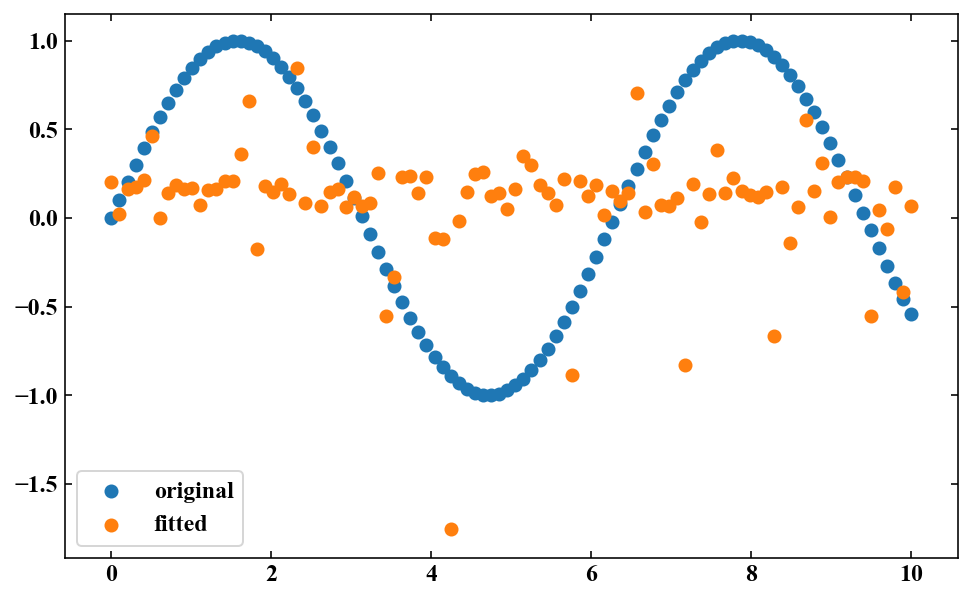

In [96]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,5))
plt.scatter(X, Y,label='original')
plt.scatter(X, model(X),label='fitted')
plt.legend()

plt.show()

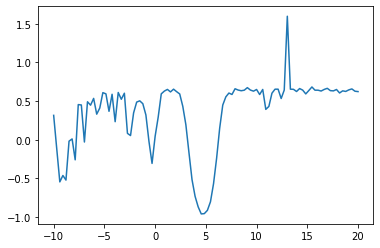

In [26]:
test_x = np.linspace(-10,20,100).reshape(-1,1) # 训练集范围如上图，是从0~10
plt.plot(test_x,model(test_x))
plt.show()

可以看到，在0~10的范围内拟合得十分不错，并且超过10的一定范围内的预测也基本是正确的。

## 使用tf.keras API实现

In [1]:
import tensorflow as tf
import numpy as np
# tf.test.is_gpu_available()
from tensorflow.keras import Input,Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D

In [2]:
def GenerateData(datasize = 200 ):
    train_X = np.linspace(0, 10, datasize)   #train_X为-1到1之间连续的100个浮点数
    train_Y = np.sin(train_X)
    yield train_X, train_Y   #以生成器的方式返回

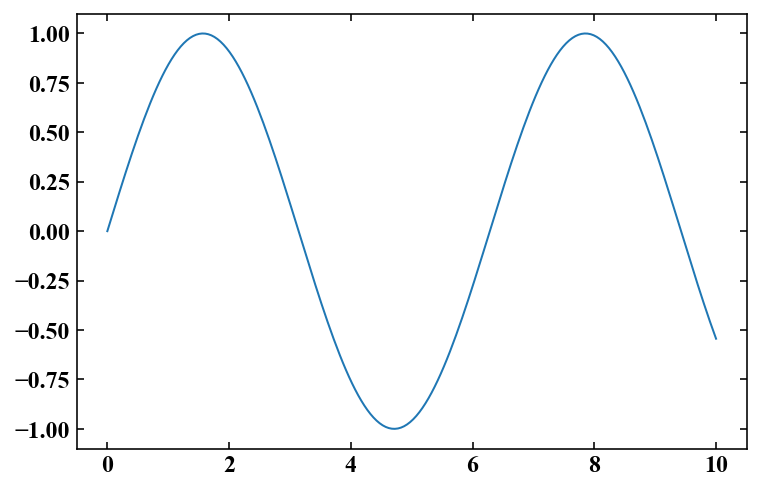

In [3]:
train_data = next(GenerateData())
plt.plot(train_data[0],train_data[1]);

In [56]:
train_data[0].shape

(200,)

In [83]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = Dense(100, activation='sigmoid') # 默认use_bias=True, tf2.0 这里不加 input_shape=(1,)
        self.fc2 = Dense(100, activation='sigmoid')
        self.out = Dense(1)
    
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x


my_model = MyModel()  
my_model0 = MyModel()

my_model(train_data[0].reshape(-1,1)).shape
my_model0(train_data[0].reshape(-1,1)).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([200, 1])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([200, 1])

In [84]:
my_model.summary()

Model: "my_model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             multiple                  200       
_________________________________________________________________
dense_64 (Dense)             multiple                  10100     
_________________________________________________________________
dense_65 (Dense)             multiple                  101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


**对上述Model使用tf.keras.models.Sequential()实现：**

In [77]:
# 使用Sequential的第一种方式
Net1 = tf.keras.Sequential()
Net1.add(Dense(100,activation='sigmoid', input_shape=(1,)))
Net1.add(Dense(100,activation='sigmoid'))
Net1.add(Dense(1))

In [78]:
# 使用Sequential的第2种方式
Net2 = tf.keras.Sequential([
    Dense(100,activation='sigmoid', input_shape=(1,)),
    Dense(100,activation='sigmoid'),
    Dense(1)
])

In [79]:
my_model.summary()
Net1.summary()
Net2.summary()

Model: "my_model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             multiple                  200       
_________________________________________________________________
dense_52 (Dense)             multiple                  10100     
_________________________________________________________________
dense_53 (Dense)             multiple                  101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_58 (Dense)             (None, 100)               10100     
_____________________________

In [80]:
my_model.weights[0].shape # w1
my_model.weights[1].shape # b1
my_model.weights[2].shape # w2
my_model.weights[3].shape # b2
Net1.weights[0].shape # w3
Net2.weights[5].shape # b3

TensorShape([1, 100])

TensorShape([100])

TensorShape([100, 100])

TensorShape([100])

TensorShape([1, 100])

TensorShape([1])

In [81]:
# Model.compile()实现反向传播
my_model.compile(loss='mse', optimizer='Adam')
Net1.compile(loss='mse', optimizer='Adam')

### 可使用两种方式训练模型：

In [82]:
# 使用集成度较低的 Model.train_on_batch方法，自行设定batch数据　和　ｅpochs
for step in range(2001):
    train_data = next(GenerateData())
    cost = my_model.train_on_batch(train_data[0].reshape(-1,1), train_data[1].reshape(-1,1))
    if step%100==0:
        print(f'loss: {cost}')

loss: 1.034376859664917
loss: 0.4348459243774414
loss: 0.42286255955696106
loss: 0.394858181476593
loss: 0.35849010944366455
loss: 0.33438220620155334
loss: 0.32149630784988403
loss: 0.31144824624061584
loss: 0.2994484007358551
loss: 0.27302664518356323
loss: 0.204842209815979
loss: 0.16085152328014374
loss: 0.1458628624677658
loss: 0.13749109208583832
loss: 0.13056577742099762
loss: 0.12407279759645462
loss: 0.11637508124113083
loss: 0.10497169196605682
loss: 0.08872434496879578
loss: 0.06900042295455933
loss: 0.048580512404441833


In [39]:
# 使用集成度较高的fit()方法，直接指定batch_size, epochs等参数
# my_model.fit(x = train_data[0].reshape(-1,1), y=train_data[1].reshape(-1,1), batch_size=100, epochs=100)
Net1.fit(x = train_data[0].reshape(-1,1), y=train_data[1].reshape(-1,1), batch_size=100, epochs=100)

Train on 200 samples
Epoch 1/100
200/200 [==============================] - 0s 54us/sample - loss: 9.6655e-04
Epoch 2/100
200/200 [==============================] - 0s 34us/sample - loss: 0.0017
Epoch 3/100
200/200 [==============================] - 0s 29us/sample - loss: 5.2419e-04
Epoch 4/100
200/200 [==============================] - 0s 63us/sample - loss: 8.8393e-04
Epoch 5/100
200/200 [==============================] - 0s 98us/sample - loss: 5.5555e-04
Epoch 6/100
200/200 [==============================] - 0s 73us/sample - loss: 0.0011
Epoch 7/100
200/200 [==============================] - 0s 59us/sample - loss: 0.0012
Epoch 8/100
200/200 [==============================] - 0s 54us/sample - loss: 6.7816e-04
Epoch 9/100
200/200 [==============================] - 0s 34us/sample - loss: 8.9960e-04
Epoch 10/100
200/200 [==============================] - 0s 54us/sample - loss: 0.0014
Epoch 11/100
200/200 [==============================] - 0s 39us/sample - loss: 9.6519e-04
Epoch 12/100
2

### 对模型进行测试评估与预测：

In [32]:
train_data = next(GenerateData())
test_x, test_y = train_data[0].reshape(-1,1), train_data[1].reshape(-1,1)

In [34]:
# 使用Model.evaluate()方法进行评估，返回 loss
cost = my_model.evaluate(test_x, test_y)
cost

# 使用Model.predict()方法进行预测,返回预测值
my_model.predict(test_x) # 它等价于　my_model(test_x).numpy()

200/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.07357557686977088

array([[ 0.1341619 ],
       [ 0.16695096],
       [ 0.20008795],
       [ 0.23355532],
       [ 0.26733276],
       [ 0.30139658],
       [ 0.3357209 ],
       [ 0.3702747 ],
       [ 0.4050233 ],
       [ 0.43992755],
       [ 0.474941  ],
       [ 0.5100117 ],
       [ 0.5450787 ],
       [ 0.5800723 ],
       [ 0.6149123 ],
       [ 0.6495064 ],
       [ 0.6837504 ],
       [ 0.7175224 ],
       [ 0.7506848 ],
       [ 0.78308284],
       [ 0.81454074],
       [ 0.84486055],
       [ 0.8738263 ],
       [ 0.9011986 ],
       [ 0.92672175],
       [ 0.9501241 ],
       [ 0.97112465],
       [ 0.9894439 ],
       [ 1.0048089 ],
       [ 1.0169727 ],
       [ 1.0257261 ],
       [ 1.0309128 ],
       [ 1.0324453 ],
       [ 1.0303153 ],
       [ 1.0245987 ],
       [ 1.0154536 ],
       [ 1.0031086 ],
       [ 0.9878454 ],
       [ 0.96996844],
       [ 0.9497792 ],
       [ 0.92754453],
       [ 0.90347457],
       [ 0.87770647],
       [ 0.85030085],
       [ 0.82124823],
       [ 0

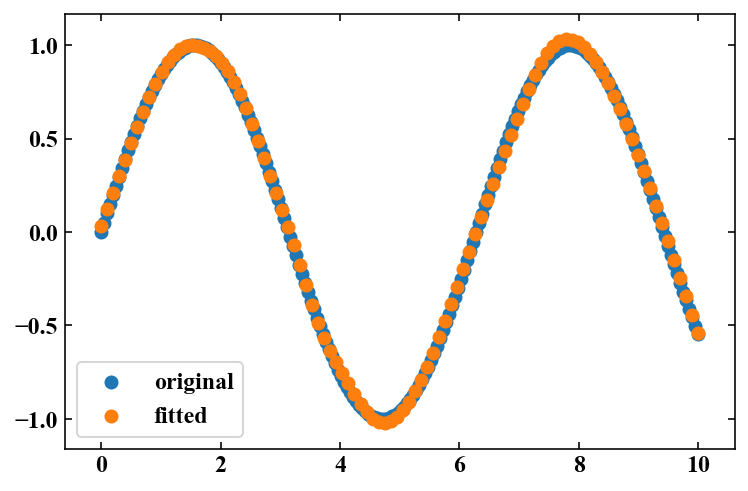

In [40]:
Tx = np.linspace(0,10,100).reshape(100,1)
plt.scatter(train_data[0],train_data[1], label = 'original');

# plt.scatter(Tx,my_model(Tx), label='fitted'); # 与下面等价
plt.scatter(Tx,my_model.predict(Tx), label='fitted');
plt.legend();

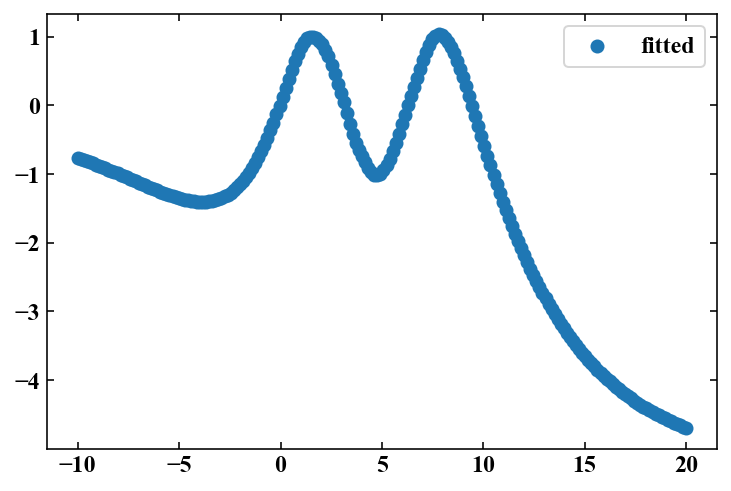

In [41]:
Tx = np.linspace(-10,20,200).reshape(200,1)
plt.scatter(Tx,my_model(Tx), label='fitted');
plt.legend();

In [112]:
# x = tf.keras.Input(shape=(32,10))# 这里shape给出的是input的特征形状，得到的x的shape其实=[batch,shape]
# y = tf.square(x)
# x

### 保存模型与加载模型
* 使用Model.save()方法保存， 通过tf.keras.models.load_model 加载模型
* 使用Model.save_weights()保存， 通过已经定义好的模型使用Model.load_weights()导入，这个已经定义好的模型结构需要与之想匹配，所以可以考虑在初始训练模型之前，做一个模型的备份。


In [113]:
my_model.save_weights('my_model.h5') # my_model只能通过save_weights保存，表示值保存了权重，但模型是没有保存的
Net1.save('Net1.h5') # 而从Sequensial建立的网络可以直接通过save保存，保存的是图+权重

del my_model
del Net1

In [114]:
from tensorflow.keras.models import load_model
# my_model0就是没有训练的MyModel()的一个实例
my_model0 = my_model0.load_weights('my_model.h5') # 保存的权重，必须用一个已经定义了的模型使用Model.load_weights()进行导入
Net1 = load_model('Net1.h5') 